In [1]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random
import logomaker as lm

import RNA
import varnaapi

sys.path.append('../')
sys.path.append('../linearbpdesign/')
sys.path.append('../script/')

import designBPaddition as addition
import designBP

In [2]:
varnaapi.set_VARNA('./VARNAv3-93.jar')

In [3]:
def min_modulo_separable(ss, modulolimit=10):
    """Compute minimum modulo separable for given structure

    Args:
        ss: input secondary structure
        modulolimit: upper bound of modulo to check
    """
    tree = designBP.dbn_to_tree(designBP.ssparse(ss))
    num_design = designBP.num_design if designBP.filter(tree) else designBP.num_design_unproper
    for m in range(2, modulolimit + 1):
        cache = {}
        res = False
        for leaf_level in designBP.part(m - 1):
            # At least one solution in this leaf_level, thus m-separable
            # We don't break for loop since we want all solutions of m-separable
            if num_design(tree, "R", 0, m, tuple(leaf_level), cache, GCweight=None) > 0:
                res = True
        if res == True:
            return m, cache
    # Here, ss is not m-separable for m up to modulolimit
    return None, None

In [4]:
class Sampler:
    """A-separable solutions sampler of given structure
    The function will add minimum number of base pair into target structure to get decrease structure modulo

    Args:
        ss: target structure
        modulolimit: upper bound of modulo to check
        uptomodulo: modulo to include in solution if min modulo if smaller
    """
    def __init__(self, ss, downto=2):
        self.target_ss = ss
        self.target_tree = designBP.dbn_to_tree(designBP.ssparse(ss))
        self.isProper = designBP.filter(self.target_tree)
        self.num_design = addition.num_design if self.isProper else addition.num_design_unproper
        self.backtrack = addition.stochastic_backtrack if self.isProper else addition.stochastic_backtrack_unproper
        self.cache = {}
        self.min_modulo = None

        self.choices = []
        self.weights = []

        k = 0
        while sum(self.weights) <= 0:
            self.choices = []
            self.weights = []
            k += 1
            for leaf_level in designBP.part(downto-1):
                self.choices.append((downto, tuple(leaf_level)))
                count = addition.num_design(self.target_tree, "R", 0, downto, tuple(leaf_level), self.cache, GCweight=None, k=k)
                self.weights.append(count)

        self.nb_added = k


    def sample(self):
        m, leaf_level = random.choices(self.choices, weights=self.weights)[0]
        seq, new_ss = self.backtrack(self.target_tree, "R", 0, m, leaf_level, self.cache, GCweight=None, k=self.nb_added)
        return seq, new_ss, m

In [5]:
def is_unique(seq):
    fc = RNA.fold_compound(seq)
    sub = fc.subopt(1)
    return len(sub)==1 or (sub[0].energy!=sub[1].energy)

def design(target, nSol=1):
    """Run RNAinverse and report result
    The function calls LinearBPDesign to decrease the modulo and remove added base pair as seed sequence
    """
    res = []
    nFound = 0
    sampler = Sampler(target)
    while nFound < nSol:
        modified_seq, modified_ss, modulo = sampler.sample()

        seed = ''.join(x for x, y in zip(modified_seq, modified_ss) if y in '(.)')
        final, bp = RNA.inverse_fold(seed, target)
        hamming = sum(x!=y for x, y in zip(seed, final))
        if (bp == 0) and is_unique(final):
            nFound += 1
            res.append([final, hamming, modified_seq, modified_ss, modulo])
    return res

In [6]:
def get_addedBP(ss):
    tmp = []
    res = []
    for ind, x in enumerate(ss):
        if x == '[':
            tmp.append(ind)
        elif x == ']':
            res.append((tmp.pop(), ind))
    return res

In [7]:
target = "((.(((.(((.(...((.((.(.(((((((.....)))(((((((.....)))))))))))).)).))...).))))))))...(((((.(((...(((.((......(((((........))))).....)).)))..)))..)))))."

In [8]:
# Minimum modulo of target structure
print(min_modulo_separable(target)[0])

5


In [9]:
res = design(target, 200)

In [10]:
np.mean([x[1] for x in res])

2.39

In [11]:
np.unique([x[1] for x in res], return_counts=True)

(array([1, 2, 3, 4, 5, 6, 8, 9]), array([82,  3, 97,  1, 12,  3,  1,  1]))

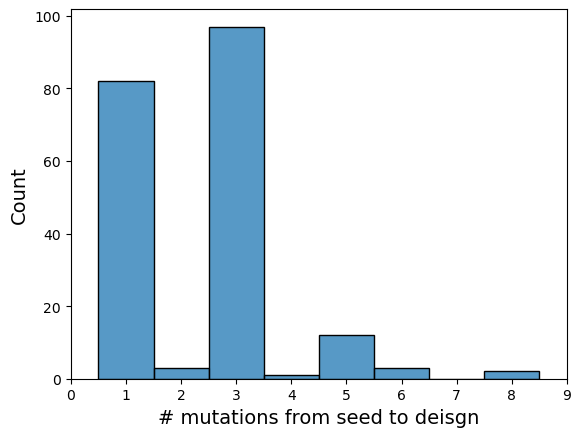

In [16]:
sns.histplot([x[1] for x in res], binwidth=1)
plt.xlabel('# mutations from seed to deisgn', fontdict={'fontsize':14})
plt.xticks([x+0.5 for x in range(10)], range(10))
plt.ylabel('Count', fontdict={'fontsize':14})
plt.savefig('../img/addition_toy_count.pdf', dpi=200, bbox_inches='tight')

In [13]:
ind = 10
modified_seq = res[ind][2]
modified_ss = res[ind][3]
print(modified_ss)
v = varnaapi.Structure(structure=modified_ss, sequence=modified_seq)
v.set_algorithm('radiate')
v.set_bp_style('simple')
v.update(flat=False)
addedBase = varnaapi.param.BasesStyle(fill="red")
for i, j in get_addedBP(modified_ss):
    v.add_aux_BP(i+1, j+1, color='red')
    v.add_bases_style(addedBase, [i+1, j+1])
v.show(full=True)
v.savefig('../img/addition_toy_ss.svg')

((.(((.(((.[(...((.((.[(.(((((((.....)))(((((((.....))))))))))))].)).))...)].))))))))...(((((.(((...(((.((......(((((........))))).....)).)))..)))..))))).


Output file: /tmp/tmpoqmyvyry.svg



JupyterSvgImage(svg='<?xml version="1.0" encoding="UTF-8"?>\n<!DOCTYPE svg PUBLIC "-//W3C//DTD SVG 1.1//EN" \n"http://www.w3.org/Graphics/SVG/1.1/DTD/svg11.dtd">\n\n<svg width="100%" height="100%" version="1.1" viewBox="0 0 900 800" \nxmlns="http://www.w3.org/2000/svg">\n<line x1="263.71399048503986" y1="557.1903921315686" x2="254.6495458311972" y2="552.9671418290854" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="245.21078659507464" y1="549.8932820086254" x2="238.6787663737442" y2="548.6122692631155" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="231.18850515990363" y1="543.3693373705914" x2="227.74882056839505" y2="537.6704908437083" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="221.62956235782295" y1="529.85425971447" x2="214.55849454595747" y2="522.7831919026046" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="207.487426734092" y1="515.712124090739" x2="200.41635892222652" y2="508.6410562788736" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="192.659483780201" y1="502.4259182662746" x2="186.3274171735023" y2="498.4064773506906" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="181.47776977254074" y1="490.7665071926943" x2="180.53530237584408" y2="483.32589377767897" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="178.21227522427338" y1="473.66149533092135" x2="174.82283325086954" y2="464.25343054006623" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="171.4333912774657" y1="454.8453657492111" x2="168.04394930406184" y2="445.43730095835593" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="162.98759945312673" y1="437.0319915698955" x2="157.94520609418277" y2="431.48013106326624" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="154.81226638127984" y1="422.7840866810486" x2="155.15529671107006" y2="415.29200979514866" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="153.689248389468" y1="405.5932159500605" x2="150.29977344360333" y2="396.1851630382538" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="144.0572860357672" y1="389.4031638853251" x2="137.23565352412143" y2="386.2862013629257" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="129.8183838641866" y1="380.11361555259435" x2="125.51409947536283" y2="373.9716890315333" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="122.24336028983595" y1="364.8931996211549" x2="121.64153042777224" y2="357.4173768365302" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="123.41786025087362" y1="347.93258073151804" x2="126.68418781974248" y2="341.1811934886743" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="127.16700207605277" y1="331.9762463437298" x2="123.77753202147892" y2="322.5681916697206" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="118.72115708240486" y1="314.16289737348706" x2="113.67874715229411" y2="308.61105191741467" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="110.54578148345806" y1="299.915016886432" x2="110.88878945090099" y2="292.4229389766888" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="109.42271218035248" y1="282.72414950750374" x2="106.03320915335328" y2="273.3161067126413" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="100.97680475624234" y1="264.91083013755645" x2="95.93437536858791" y2="259.35900235367205" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="92.80137922274295" y1="250.66297830285987" x2="93.14436093266889" y2="243.17089919102136" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="91.67824967074381" y1="233.4721148600628" x2="88.28871367136088" y2="224.0640839444627" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="83.81607059010167" y1="215.2027364057236" x2="80.13663889564663" y2="209.69614630580134" stroke="rgb(35%, 35%, 35%)" stroke-width="1.0" />\n<line x1="78.56305460381209" y1="200.6860125913969" x2="80.15819677938605" y2="194.25823898287365" stroke="rgb(

Output file: ../img/addition_toy_ss.svg



In [17]:
modified_seq

'GGAGACACUGAGGAAAGGAGGAGGAGACCAACAAAAAGUUUUGGAAGAAAAACUUCCAAGGUCCCACCACCAAACCACAGGUCCCAAACCCACACUGAAAGUCACCAAAAAACAAAGAAAAAAAACUUUGAAAAAGGAGACAACAGAAGUGGGA'

In [18]:
modified_ss

'((.(((.(((.[(...((.((.[(.(((((((.....)))(((((((.....))))))))))))].)).))...)].))))))))...(((((.(((...(((.((......(((((........))))).....)).)))..)))..))))).'